# Convergence and Checks with Bayes

**Authors**: original R Tutorial created by Sara van Erp; Python translation by Florian Metwaly.

This document illustrates different convergence criteria and model checking possibilities in `PyMC` using `arviz`, which is the program underlying the `bambi` library.

## Preliminaries

If you are using Google Colab, remove the # from the following line and run the chunk to install the `bambi` library:

In [2]:
#!pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.7 MB/s eta 0:00:00


In [59]:
import bambi as bmb # BAyesian Model-Building Interface in Python
import arviz as az # Exploratory analysis of Bayesian models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

SEED = 1337

## An example: Predicting students' math performance.

To illustrate Bayesian convergence and checks, we will use a data set that is available from the [UCI Machine Learning repository](https://archive.ics.uci.edu). The data set we use can be downloaded [here](https://archive.ics.uci.edu/dataset/320/student+performance) and contains two data sets and a merged file. We will use the "student-mat.csv" file.

We will use linear regression analysis to predict the final math grade of Portugese students in secondary schools. First, we load in the data. Make sure the data is saved in your current working directory or change the path to the data in the code below.

In [4]:
dat = pd.read_csv("student-mat.csv", sep=";")
print(dat.head())

  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]


We will predict the math grade at the third period *G3* based on student's sex (*sex*), the weekly time spent studying (*studytime*), whether the student has additional paid mathematics classes (*paid*), and whether the student wants to take higher education (*higher*).

In [5]:
model1 = bmb.Model("G3 ~ sex + studytime + paid + higher", data=dat,
                  center_predictors=False)
fit1 = model1.fit(random_seed=SEED)

Output()

In [6]:
az.summary(fit1)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept    4.702  1.136   2.549    6.770      0.039    0.024     850.0   
higher[yes]  3.657  1.057   1.655    5.578      0.031    0.022    1165.0   
paid[yes]    0.682  0.458  -0.160    1.530      0.011    0.010    1786.0   
sex[M]       1.574  0.478   0.695    2.499      0.013    0.010    1381.0   
sigma        4.454  0.158   4.155    4.738      0.004    0.004    1680.0   
studytime    0.580  0.291   0.013    1.100      0.008    0.007    1497.0   

             ess_tail  r_hat  
Intercept      1179.0    1.0  
higher[yes]    1162.0    1.0  
paid[yes]      1225.0    1.0  
sex[M]         1266.0    1.0  
sigma          1203.0    1.0  
studytime      1390.0    1.0

Note that here, we rely on the default prior distributions in `bambi`. Based on the point estimates, we could conclude that whether the student wants to take higher education, their sex, and, to a lesser extent, time spent studying can predict the math grade at the third period. However, to fully trust these results, we want to make sure that the model has converged. Luckily, `bambi` will provide warnings whenever the model does not seem to have converged based on numeric cutoffs. Fortunately, convergence seems fine here.

## Convergence

Generally, for simple models you are not likely to run into convergence issues. However, as models become more complex, sampling from the posterior might prove to be more difficult and convergence issues can arise. If this is the case, there are multiple potential solutions:

1. Change sampler settings, e.g., run more iterations
2. Change the priors
3. Change the model

Below, a short summary on checking convergence with `bambi` is provided. Extensive information on convergence issues with `PyMC` can be found [here](https://pymcmc.readthedocs.io/en/latest/modelchecking.html), which is a highly recommended read. For many examples of convergence checks for different models, you can check out the [examples gallery](https://bambinos.github.io/bambi/notebooks/) of the `bambi` documentation.

### Visual diagnostics

First, we can look at the density and traceplots for a specific parameters:

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>]], dtype=object)

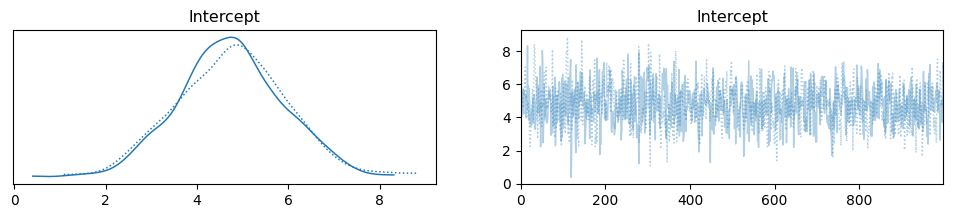

In [ ]:
az.plot_trace(fit1, var_names=["Intercept"])

Or we can plot density and traceplots for all parameters simultaneously:

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'higher'}>,
        <Axes: title={'center': 'higher'}>],
       [<Axes: title={'center': 'paid'}>,
        <Axes: title={'center': 'paid'}>],
       [<Axes: title={'center': 'sex'}>, <Axes: title={'center': 'sex'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'studytime'}>,
        <Axes: title={'center': 'studytime'}>]], dtype=object)

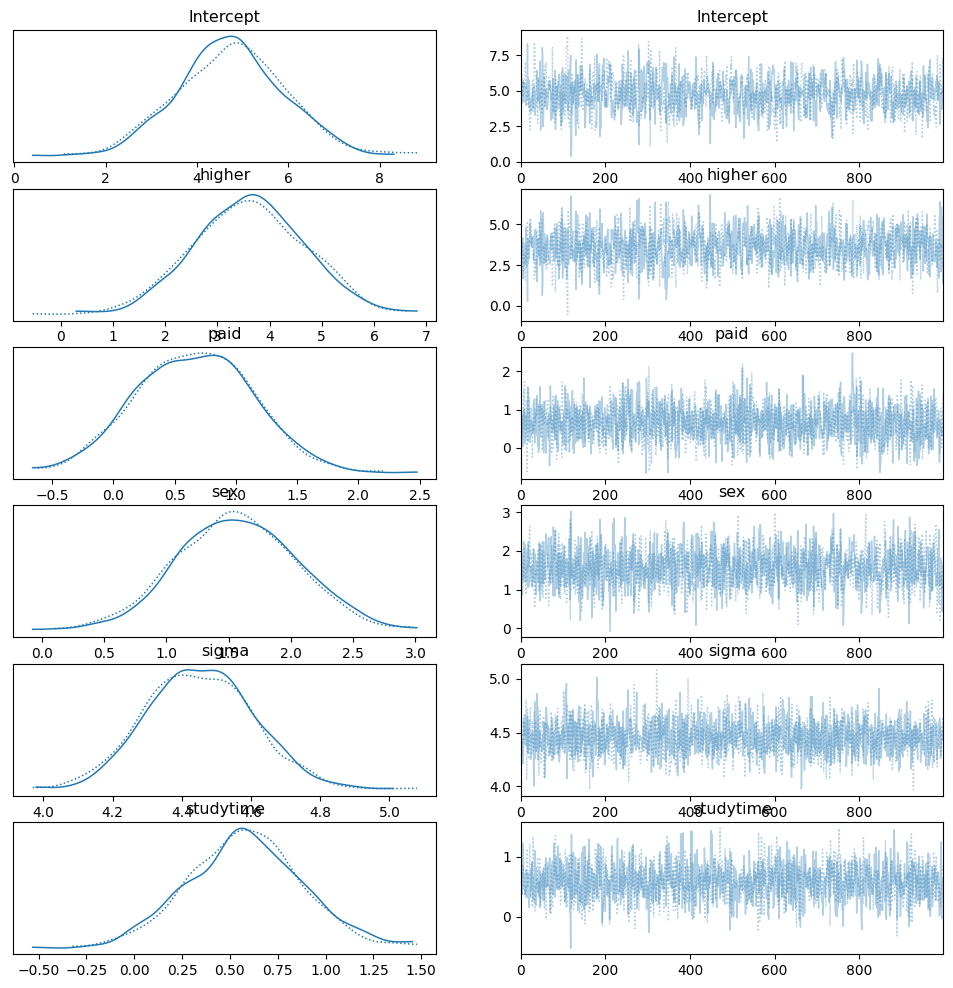

In [ ]:
az.plot_trace(fit1)

### Numerical diagnostics

There are several numerical diagnostics to check. Some cutoffs for each diagnostic are presented below but remember that these are arbitrary cutoffs and in the end, all available information should be combined to guide assessment of convergence.

- Rhat: ratio of the variance between and within chains. Values of 1 indicate convergence, larger values indicate non-convergence. General cutoff: Rhat < 1.01.
- Effective sample size: how many independent samples contain the same amount of information as the dependent samples obtained? Bulk-ESS estimates sampling efficiency for point summaries such as the posterior mean and should be about 100 times the number of chains. Tail-ESS estimates sampling efficiency for the posterior tails.
- Divergent transitions: indicate that our iteration steps too far and moves away from the actual posterior density. Even a small number can bias the results, but just a few divergences and good Rhat and ESS values can provide a sufficiently reliable posterior.
- Max. treedepth exceeded: a warning that your sampler is not as efficient. If this is your only warning and other diagnostics are good, you can ignore this warning.
- Low Bayesian Fraction of Missing Information (BFMI): indicates that the posterior distribution was not well explored.

### Solving problems

By default, `bambi` will run 4 chains of 2000 MCMC samples each in which the first 1000 draws are removed as burn-in. As a result, 4000 samples remain for inference. (Note: On Google Collab the default number of chains is set to 2!).

If Rhat is too high or ESS or BFMI too low, try to increase the number of iterations. This can be done via the `draws` argument. Note that by default, half of the number of iterations is removed as burn-in so to avoid removing too much samples as burn-in, you can additionally specify the `tune` to remain at 1000 iterations.

In [7]:
fit2 = model1.fit(random_seed=SEED, draws=4000, tune=1000, chains=4)

Output()

If increasing the number of iterations does not help, you should carefully revisit your model and respecify or introduce more information via stronger priors.

Divergent transitions are more tricky since they indicate a problem or a difficulty with sampling from the posterior distribution which is rarely solved by increasing the number of iterations. Instead, you could try to increase the target average proposal acceptance probability via `target_accept`. The default is 0.80 which you can increase to, for example, 0.90 although this will slow down the sampling.

In [8]:
fit3 = model1.fit(random_seed=SEED, target_accept=0.9)

Output()

## Posterior predictive checks

`bambi` and `arviz` have several posterior predictive checks built in. For example, we can compare the sample means of replicated data sets to the observed data. To do this, we first have to calculate the posterior mean and sd per draws:

In [76]:
# Extract and stack the prior predictive samples
y_post = fit1["posterior_predictive"].stack(sample=("chain", "draw"))

# Compute mean for each sample
means_per_draw_post = y_post.mean(dim="__obs__")

# Compute std for each sample
sds_per_draw_post = y_post.std(dim="__obs__")

Now we can plot the means:

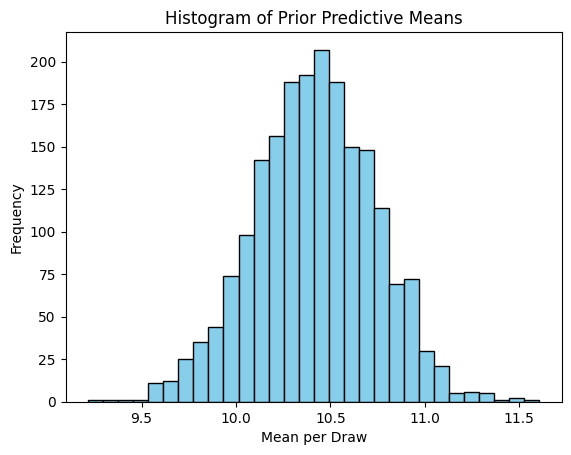

In [77]:
plt.hist(means_per_draw_post["G3"], bins=30, color="skyblue", edgecolor="black")
plt.title("Histogram of Prior Predictive Means")
plt.xlabel("Mean per Draw")
plt.ylabel("Frequency")
plt.show()

Or standard deviations

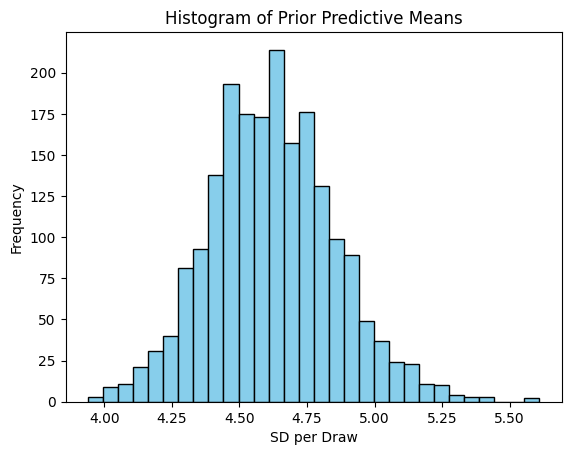

In [78]:
plt.hist(sds_per_draw_post["G3"], bins=30, color="skyblue", edgecolor="black")
plt.title("Histogram of Prior Predictive Means")
plt.xlabel("SD per Draw")
plt.ylabel("Frequency")
plt.show()

Or both combined:

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(means_per_draw_post["G3"], sds_per_draw_post["G3"], alpha=0.5)
plt.title("Mean vs SD of Posterior Predictive Draws")
plt.xlabel("Mean per Draw")
plt.ylabel("SD per Draw")
plt.show()

These posterior predictive checks all show that generated data based on the model resembles the observed data quite well.
However, suppose we are not just interested in accurately capturing the mean and standard deviation of the math grades but we also want to accurately capture the percentage of students who pass the course. We can check whether our model accurately represents this quantity by conducting a posterior predictive check using a custom test statistic.

First, let's compute the percentage of students who pass the course in the observed data. The math grade ranges from 0 to 20 and a grade equal to or higher than 10 means a pass:

In [60]:
yobs = dat["G3"]
pass_obs = (yobs >= 10).sum() / len(yobs) * 100
pass_obs

np.float64(67.08860759493672)

Now, let's write a function that can compute the percentage of students who pass the course for data sets generated from the posterior predictive distribution. We use the `posterior_predict` function to generate 4000 data sets containing 395 y-values: one data set per posterior draw.

In [29]:
def passPerc(model, fit):
    model.predict(fit, kind="pps")
    yrep = fit.posterior_predictive["G3"]

    # Combine chain and draw dimensions to get total samples
    yrep_flat = yrep.stack(sample=("chain", "draw"))  # shape: (sample=2000, obs=395)

    # Compute percentage of observations ≥ threshold for each sample
    pass_percentages = (yrep_flat >= 10).sum(dim="__obs__") / yrep_flat.sizes["__obs__"] * 100

    return pass_percentages

We can now plot the pass percentages for the generated data and compare them to the observed percentage:

In [25]:
pass_rates = passPerc(model1, fit1)

plt.hist(pass_rates, bins=30, color="skyblue", edgecolor="black")
plt.axvline(pass_obs, color="red", linestyle="--", linewidth=2, label=f"Observed ({pass_obs:.1f}%)")

plt.xlim(40, 70)
plt.xlabel("Percentage of students passing (G3 ≥ 10)")
plt.ylabel("Frequency")
plt.title("Posterior Predictive Distribution of Pass Rate")
plt.legend()
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/bambi/models.py:858: FutureWarning: 'pps' has been replaced by 'response' and is not going to work in the future
  warnings.warn(


We see that our model does not capture this percentage well. We can further quantify this by computing the posterior predictive p-value, which equals zero in this case because none of the generated data sets exceed the observed pass percentage.

In [70]:
print(f"{sum(pass_rates >= pass_obs) / len(pass_rates) * 100:.2f}")

0.00


If we look at a simple graphical posterior predictive check, we can see what is going wrong:

<Axes: xlabel='G3'>

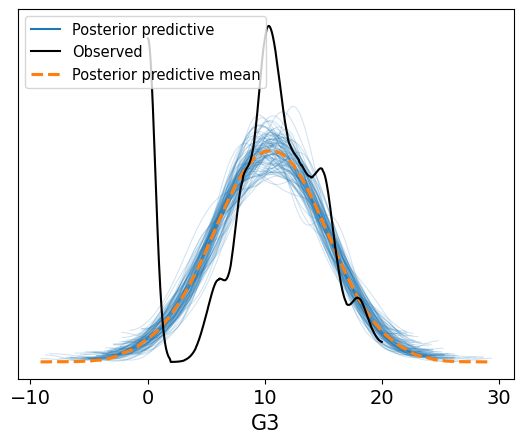

In [72]:
az.plot_ppc(fit1, num_pp_samples=100)

Our data contains much more students who got a zero than our model predicts^[Note that if we would have looked at our data before fitting the model as we should always do, we could have predicted that our normal model would not fit well.]. The nice thing about this check is that this immediately shows how we might improve our model: we need to allow for more zeros. This can be done in using a hurdle model, such as the [hurdle log-normal](https://www.andrewheiss.com/blog/2022/05/09/hurdle-lognormal-gaussian-brms/#hurdle-lognormal-model). Unfortunately, `bambi` has [not yet implemented](https://bambinos.github.io/bambi/notebooks/getting_started.html) the hurdle log-normal model. A direct implementation through `PyMC` [is possible](https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.HurdleLogNormal.html) but extends the scope of this tutorial.

## Prior predictive checks

We can use the same intuition to generate data from the prior predictive distribution before we run the analysis. This can be done to assess whether our priors make sense.

To do this, we use the `bambi` model object to sample from the prior distribution:

<Axes: xlabel='G3'>

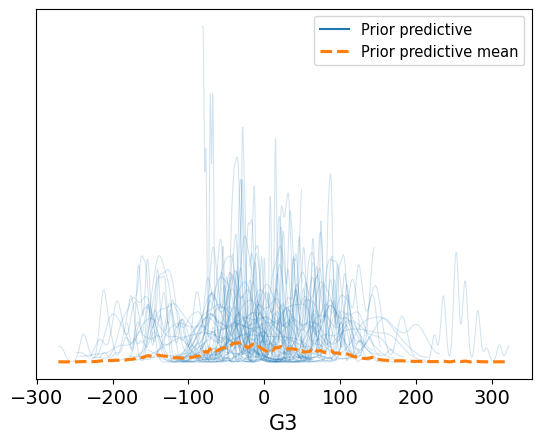

In [73]:
idata_prior = model1.prior_predictive(draws=500, random_seed=SEED)
az.plot_ppc(idata_prior, group="prior", num_pp_samples=100, random_seed=SEED)

## References

Cortez, P., & Silva, A. M. G. (2008). Using data mining to predict secondary school student performance. In A. Brito & J. Teixeira (Eds.), *Proceedings of the 5th Future Business Technology Conference* (pp. 5–12).

Lichman, M. (2013). *UCI Machine Learning Repository*. University of California, Irvine, School of Information and Computer Sciences. http://archive.ics.uci.edu/ml

Stan Development Team. (2022). *Runtime warnings and convergence problems*. https://mc-stan.org/misc/warnings.html#diagnosing-and-resolving-problems